# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções Auxiliares](#Funções-Auxiliares)

[Funções de Custo](#Funções-de-Custo)

[Inicialização de Pesos](#Inicialização-de-Pesos)

[Regularização](#Regularização)

[Learning Rate Decay](#Learning-Rate-Decay)

[Batch Normalization](#Batch-Normalization)

[Batch Generator](#Batch-Generator)

[Implementação](#Implementação)

[Testes da Implementação](#Testes-da-Implementação)

- [Exemplos do Notebook da Intuição](#Exemplos-do-Notebook-da-Intuição)

- [Regressão](#Regressão)
    - [Regressão Linear Simples](#Regressão-Linear-Simples---Exemplo-do-Perceptron)
    - [Regressão Linear Multivariada](#Regressão-Linear-Multivariada---Exerc%C3%ADcio-de-Regressão-do-Perceptron)
    - [Regressão Quadrática](#Regressão-Quadrática)
    - [Regressão Cúbica](#Regressão-Cúbica)
    - [Regressão Logarítimica](#Regressão-Logar%C3%ADtimica)
    - [Regressão Exponencial](#Regressão-Exponencial)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Moons](#Moons)
    - [Espiral](#Espiral)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)
    - [3 Clusters Multiclasse](#3-Clusters-Multiclasse)
    - [4 Clusters Multiclasse](#4-Clusters-Multiclasse)
    - [Espiral - 5 Classes](#Espiral---5-Classes)
    - [Make Classification - 4 Classes](#Make-Classification---4-Classes)
    - [Iris Dataset](#Iris-Dataset)

[Referências](#Referências)

# Imports and Configurações

In [3]:
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plots
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10
from utils.grad_check import gradient_checking

%matplotlib inline

# Funções de Ativação

In [4]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    alpha = 0.1
    if derivative:
        return np.where(x <= 0, alpha, 1)
    return np.where(x <= 0, alpha*x, x)

def elu(x, derivative=False):
    alpha = 1.0
    if derivative:
        y = elu(x)
        return np.where(x <= 0, y + alpha, 1)
    return np.where(x <= 0, alpha*(np.exp(x) - 1), x)

# Funções Auxiliares

In [5]:
def softmax(x, y_oh=None, derivative=False):
    if derivative: 
        y_pred = softmax(x)
        y_correct = np.argmax(y_oh, axis=1)
        pk = y_pred[range(y_pred.shape[0]), y_correct]
        y_pred[range(y_pred.shape[0]), y_correct] = pk*(1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

def neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_pred[range(y_pred.shape[0]), y_correct]
    if derivative:
        y_pred[range(y_pred.shape[0]), y_correct] = (-1.0/pk)
        return y_pred
    return np.mean(-np.log(pk))

# Funções de Custo

###### Para Regressão

In [7]:
def mae(y, y_pred, derivative=False):
    if derivative:
        return np.where(y_pred > y, 1, -1) / y.shape[0]
    return np.mean(np.abs(y - y_pred))

def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / y.shape[0]
    return 0.5*np.mean((y - y_pred)**2)

###### Para Classificação Binária

In [8]:
def binary_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / (y_pred * (1-y_pred) * y.shape[0])
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

def sigmoid_cross_entropy(y, y_pred, derivative=False):
    y_sigmoid = sigmoid(y_pred)
    if derivative:
        return -(y - y_sigmoid) / y.shape[0]
    return -np.mean(y*np.log(y_sigmoid) + (1-y)*np.log(1-y_sigmoid))

###### Para Classificação Multiclasse

In [9]:
def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_softmax[range(y_softmax.shape[0]), y_correct]
    if derivative:
        return -(y_oh - y_softmax)/y_oh.shape[0]
    return np.mean(-np.log(pk))

# Inicialização de Pesos

In [58]:
def zeros(rows, cols):
    return np.zeros((rows, cols))

def ones(rows, cols):
    return np.ones((rows, cols))

def random_normal(rows, cols):
    return np.random.randn(rows, cols)

def random_uniform(rows, cols):
    return np.random.rand(rows, cols)

def glorot_normal(rows, cols):
    # normal com média 0 e stddev=sqrt(2.0/(out+inp))
    std_dev = np.sqrt(2.0 / (rows + cols))
    return std_dev * np.random.randn(rows, cols)

def glorot_uniform(rows, cols):
    # uniforme de [-limit, limit], limit = np.sqrt(6.0 / (out + inp))
    limit = np.sqrt(6.0 / (rows + cols))
    return 2*limit*np.random.rand(rows, cols) - limit


# Regularização

# Batch Generator

# Learning Rate Decay

# Batch Normalization 

# Implementação 

In [10]:
class Layer():
    def __init__(self, input_dim, output_dim, 
                 activation=linear,
                 weights_initializer=random_normal,
                 biases_initializer=ones):

        self.input = None
        self.weights = weights_initializer(output_dim, input_dim)
        self.biases = biases_initializer(output_dim, input_dim)
        self.activation = activation
        
        self._activ_inp, self._activ_out = None, None
        self._dweights, self._dbiases = None, None

class NeuralNetwork():
    def __init__(self, cost_func=mse, learning_rate=1e-3):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = learning_rate
    
    def fit(self, x_train, y_train, epochs=100, verbose=10):
        for epoch in range(epochs + 1):
            y_pred = self.__feedforward(x_train)
            self.__backprop(y_train, y_pred)
            if epoch % verbose == 0:
                loss_train = self.cost_func(y_train, self.predict(x_train))
                print("epoch: {0:=4}/{1} loss_train: {2:.8f}".format(
                    epoch, epochs, loss_train))
    
    def predict(self, x):
        return self.__feedforward(x)
    
    def __feedforward(self, x):
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:] + [Layer(0,0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            current_layer._activ_inp = y
            current_layer._activ_out = next_layer.input = current_layer.activation(y)
        return self.layers[-1]._activ_out
    
    def __backprop(self, y, y_pred):
        last_delta = self.cost_func(y, y_pred, derivative=True)
        for layer in reversed(self.layers):
            dactivation = layer.activation(layer._activ_inp, derivative=True) * last_delta
            last_delta = np.dot(dactivation, layer.weights)
            layer._dweights = np.dot(dactivation.T, layer.input)
            layer._dbiases = 1.0 * dactivation.sum(axis=0, keepdims=True)
        for layer in reversed(self.layers):
            layer.weights = layer.weights - self.learning_rate * layer._dweights
            layer.biases = layer.biases - self.learning_rate * layer._dbiases


## Exemplos do Notebook da Intuição

### Exemplo 1

In [22]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]]) 
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]])

# insira sua rede aqui!
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=0.5)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=sigmoid))

nn.layers[0].weights = w1
nn.layers[0].biases = b1
nn.layers[1].weights = w2
nn.layers[1].biases = b2

nn.fit(x, y, epochs=0, verbose=1)

for layer in nn.layers:
    print(layer.weights)


epoch:    0/0 loss_train: 0.14023572
[[0.14978072 0.19956143]
 [0.24975114 0.29950229]]
[[0.35891648 0.40866619]
 [0.51130127 0.56137012]]


### Exemplo 2

In [24]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])
D_in, D_out = x.shape[1], y.shape[1]

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=0.01)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=3, activation=sigmoid))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

nn.layers[0].weights = w1
nn.layers[0].biases = b1
nn.layers[1].weights = w2
nn.layers[1].biases = b2
nn.layers[2].weights = w3
nn.layers[2].biases = b3

nn.fit(x, y, epochs=300, verbose=10)

for layer in nn.layers:
    print(layer.weights)


epoch:    0/300 loss_train: 1.14054966
epoch:   10/300 loss_train: 0.90689401
epoch:   20/300 loss_train: 0.72956286
epoch:   30/300 loss_train: 0.59630022
epoch:   40/300 loss_train: 0.49588952
epoch:   50/300 loss_train: 0.41941978
epoch:   60/300 loss_train: 0.36031189
epoch:   70/300 loss_train: 0.31386980
epoch:   80/300 loss_train: 0.27677761
epoch:   90/300 loss_train: 0.24668884
epoch:  100/300 loss_train: 0.22192766
epoch:  110/300 loss_train: 0.20128187
epoch:  120/300 loss_train: 0.18386202
epoch:  130/300 loss_train: 0.16900591
epoch:  140/300 loss_train: 0.15621341
epoch:  150/300 loss_train: 0.14510157
epoch:  160/300 loss_train: 0.13537333
epoch:  170/300 loss_train: 0.12679548
epoch:  180/300 loss_train: 0.11918285
epoch:  190/300 loss_train: 0.11238684
epoch:  200/300 loss_train: 0.10628708
epoch:  210/300 loss_train: 0.10078511
epoch:  220/300 loss_train: 0.09579980
epoch:  230/300 loss_train: 0.09126370
epoch:  240/300 loss_train: 0.08712037
epoch:  250/300 loss_trai

## Gradient Checking

In [ ]:
np.random.seed(1234)
N, D = 100, 2
x = np.random.rand(N, D)
y = np.random.rand(N, 1)

In [ ]:
# regression
D_in, D_out = x.shape[1], y.shape[1]
# insira sua rede aqui!

In [ ]:
# binary classification
y = np.random.randint(0, 2, (N, 1))

D_in, D_out = x.shape[1], y.shape[1]
# insira sua rede aqui!

In [ ]:
# multiclass classification
y = np.random.randint(0, 2, (N, 1))
y_oh = OneHotEncoder(sparse=False).fit_transform(y)

D_in, D_out = x.shape[1], y_oh.shape[1]
# insira sua rede aqui!

## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

(100, 2)
(100, 1) (100, 1)


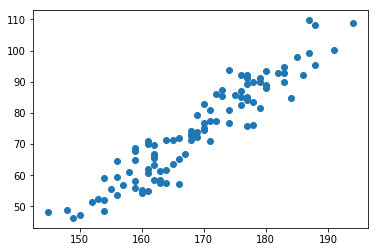

In [25]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)
plt.scatter(x, y)

-1.0 0.9999999999999991


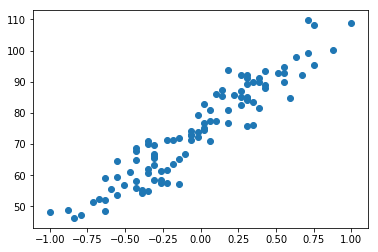

In [26]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())
plt.scatter(x, y)

epoch:    0/5000 loss_train: 2813.10541877
epoch:  500/5000 loss_train: 30.78700702
epoch: 1000/5000 loss_train: 15.75651092
epoch: 1500/5000 loss_train: 13.45957366
epoch: 2000/5000 loss_train: 13.10584700
epoch: 2500/5000 loss_train: 13.05137324
epoch: 3000/5000 loss_train: 13.04298430
epoch: 3500/5000 loss_train: 13.04169241
epoch: 4000/5000 loss_train: 13.04149346
epoch: 4500/5000 loss_train: 13.04146282
epoch: 5000/5000 loss_train: 13.04145810


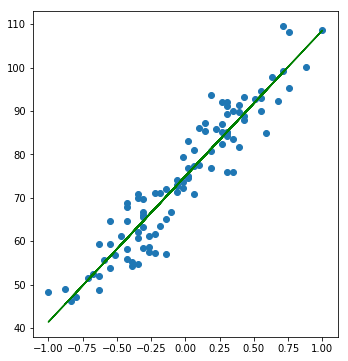

In [27]:
D_in, D_out = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=5000, verbose=500)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [28]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


[-1. -1. -1.] [1. 1. 1.]


ValueError: x and y must be the same size

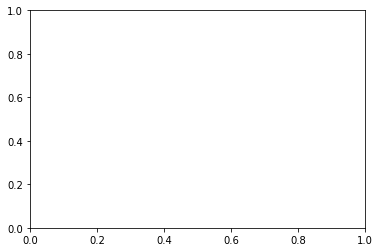

In [29]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))
plt.scatter(x, y)

In [ ]:
D_in, D_out = x.shape[1], y.shape[1]

# insira sua rede aqui!

### Regressão Quadrática

(100, 1) (100, 1)


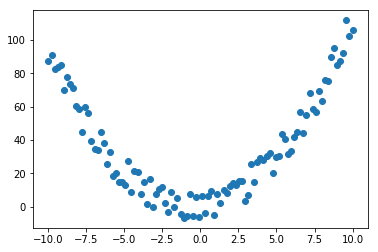

In [32]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [33]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/30000 loss_train: 1152.49603770
epoch: 3000/30000 loss_train: 101.48194392
epoch: 6000/30000 loss_train: 30.66410928
epoch: 9000/30000 loss_train: 21.80148534
epoch: 12000/30000 loss_train: 18.37376248
epoch: 15000/30000 loss_train: 17.74446818
epoch: 18000/30000 loss_train: 17.48485831
epoch: 21000/30000 loss_train: 17.34851141
epoch: 24000/30000 loss_train: 17.26247981
epoch: 27000/30000 loss_train: 17.20005941
epoch: 30000/30000 loss_train: 17.14964963


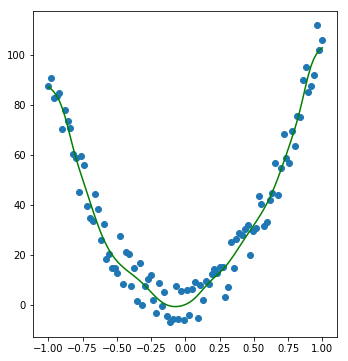

In [38]:
D_in, D_out = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)

nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=tanh))
nn.layers.append(Layer(input_dim=5, output_dim=8, activation=sigmoid))
nn.layers.append(Layer(input_dim=8, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=30000, verbose=3000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

(100, 1) (100, 1)


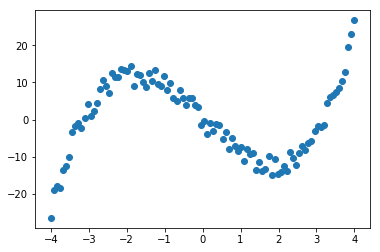

In [11]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [12]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/30000 loss_train: 55.09799408
epoch: 3000/30000 loss_train: 54.01060623
epoch: 6000/30000 loss_train: 49.75441344
epoch: 9000/30000 loss_train: 27.51652035
epoch: 12000/30000 loss_train: 9.52981867
epoch: 15000/30000 loss_train: 5.51170119
epoch: 18000/30000 loss_train: 4.17032318
epoch: 21000/30000 loss_train: 3.48784772
epoch: 24000/30000 loss_train: 3.06824785
epoch: 27000/30000 loss_train: 2.76816054
epoch: 30000/30000 loss_train: 2.52639124


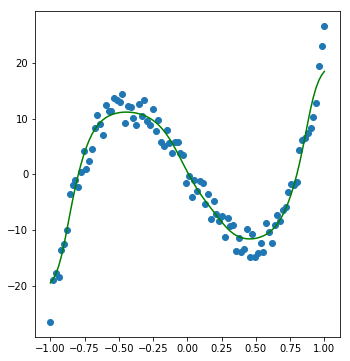

In [13]:
D_in, D_out = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)

nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=tanh))
nn.layers.append(Layer(input_dim=5, output_dim=8, activation=sigmoid))
nn.layers.append(Layer(input_dim=8, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=30000, verbose=3000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

(100, 1) (100, 1)


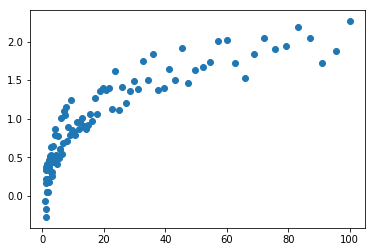

In [20]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [21]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/30000 loss_train: 1.15021170
epoch: 3000/30000 loss_train: 0.04184556
epoch: 6000/30000 loss_train: 0.02851919
epoch: 9000/30000 loss_train: 0.02619943
epoch: 12000/30000 loss_train: 0.02543048
epoch: 15000/30000 loss_train: 0.02491321
epoch: 18000/30000 loss_train: 0.02448419
epoch: 21000/30000 loss_train: 0.02411503
epoch: 24000/30000 loss_train: 0.02379385
epoch: 27000/30000 loss_train: 0.02351219
epoch: 30000/30000 loss_train: 0.02326343


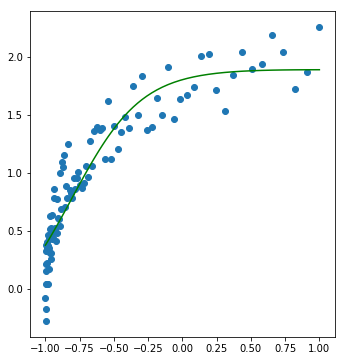

In [22]:
D_in, D_out = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)

nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=tanh))
nn.layers.append(Layer(input_dim=5, output_dim=8, activation=sigmoid))
nn.layers.append(Layer(input_dim=8, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=30000, verbose=3000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

(100, 1) (100, 1)


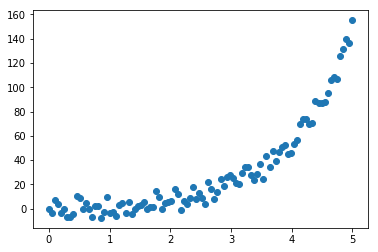

In [17]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [18]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/30000 loss_train: 1210.77980372
epoch: 3000/30000 loss_train: 50.24577734
epoch: 6000/30000 loss_train: 23.36850104
epoch: 9000/30000 loss_train: 17.50929232
epoch: 12000/30000 loss_train: 15.40734527
epoch: 15000/30000 loss_train: 14.50519149
epoch: 18000/30000 loss_train: 14.10070077
epoch: 21000/30000 loss_train: 13.91389494
epoch: 24000/30000 loss_train: 13.81965543
epoch: 27000/30000 loss_train: 13.76509482
epoch: 30000/30000 loss_train: 13.72898321


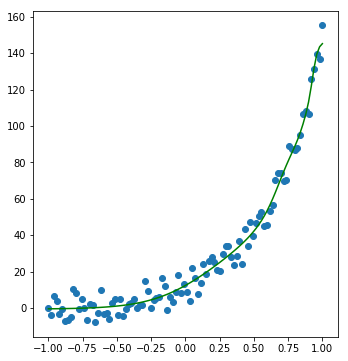

In [19]:
D_in, D_out = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)

nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=tanh))
nn.layers.append(Layer(input_dim=5, output_dim=8, activation=sigmoid))
nn.layers.append(Layer(input_dim=8, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=30000, verbose=3000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

(4, 2) (4, 1)


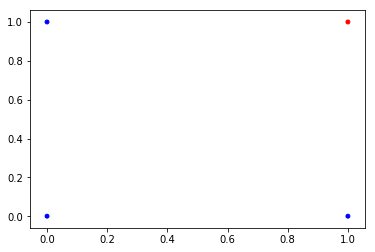

In [23]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/1000 loss_train: 0.52128472
epoch:  100/1000 loss_train: 0.38681645
epoch:  200/1000 loss_train: 0.31714300
epoch:  300/1000 loss_train: 0.27042468
epoch:  400/1000 loss_train: 0.23648627
epoch:  500/1000 loss_train: 0.21046432
epoch:  600/1000 loss_train: 0.18974512
epoch:  700/1000 loss_train: 0.17278768
epoch:  800/1000 loss_train: 0.15861591
epoch:  900/1000 loss_train: 0.14657603
epoch: 1000/1000 loss_train: 0.13621048
Predições:
[[0.00712618]
 [0.14320748]
 [0.14338057]
 [0.79583039]]
Acurácia: 100.00%


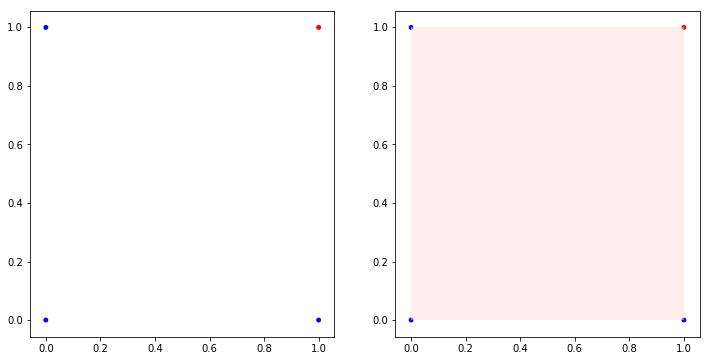

In [26]:
D_in, D_out = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)

nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=1000, verbose=100)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, cmap='bwr')

### Porta XOR

(4, 2) (4, 1)


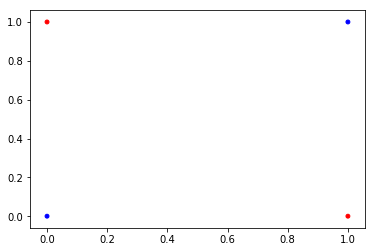

In [27]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/30000 loss_train: 0.93842194
epoch: 3000/30000 loss_train: 0.93839246
epoch: 6000/30000 loss_train: 0.93836299
epoch: 9000/30000 loss_train: 0.93833353
epoch: 12000/30000 loss_train: 0.93830407
epoch: 15000/30000 loss_train: 0.93827461
epoch: 18000/30000 loss_train: 0.93824516
epoch: 21000/30000 loss_train: 0.93821571
epoch: 24000/30000 loss_train: 0.93818627
epoch: 27000/30000 loss_train: 0.93815683
epoch: 30000/30000 loss_train: 0.93812740
Predições:
[[0.86101711]
 [0.61002628]
 [0.89907554]
 [0.69224882]]
Acurácia: 50.00%


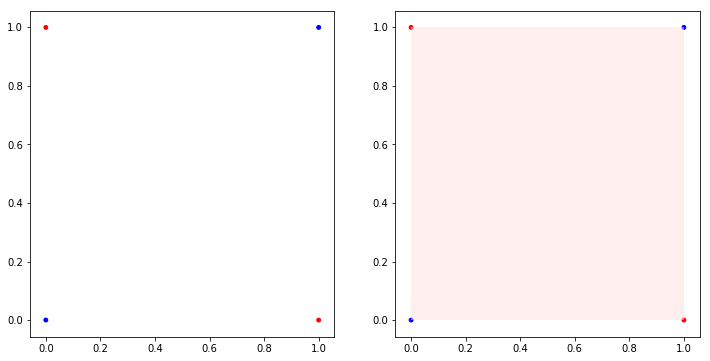

In [33]:
D_in, D_out = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-7)

nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=30000, verbose=3000)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, cmap='bwr')

### 2 Clusters

(100, 2) (100, 1)


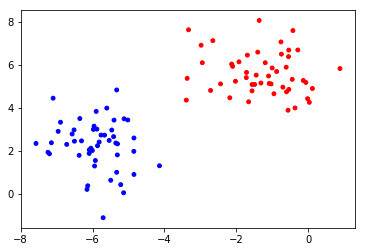

In [35]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/30000 loss_train: 3.93132827
epoch: 3000/30000 loss_train: 0.07651843
epoch: 6000/30000 loss_train: 0.04165336
epoch: 9000/30000 loss_train: 0.03017060
epoch: 12000/30000 loss_train: 0.02428236
epoch: 15000/30000 loss_train: 0.02063999
epoch: 18000/30000 loss_train: 0.01813677
epoch: 21000/30000 loss_train: 0.01629609
epoch: 24000/30000 loss_train: 0.01487722
epoch: 27000/30000 loss_train: 0.01374479
epoch: 30000/30000 loss_train: 0.01281653
Acurácia: 100.00%


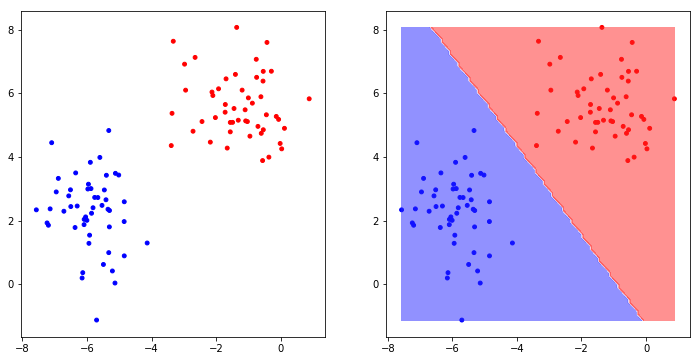

In [37]:
D_in, D_out = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-3)

nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=30000, verbose=3000)

y_pred = nn.predict(x)

threshold = 0 if nn.layers[-1].activation == linear else 0.5
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred >= threshold)))
plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=threshold, cmap='bwr')

### 4 Clusters

(500, 2) (500, 1)


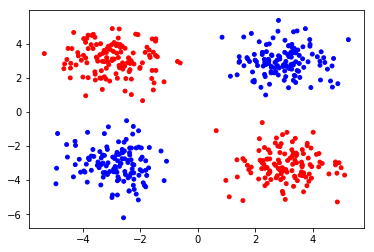

In [38]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/30000 loss_train: 1.44419947
epoch: 3000/30000 loss_train: 0.18851929
epoch: 6000/30000 loss_train: 0.10159160
epoch: 9000/30000 loss_train: 0.07487226
epoch: 12000/30000 loss_train: 0.06215120
epoch: 15000/30000 loss_train: 0.05455982
epoch: 18000/30000 loss_train: 0.04932767
epoch: 21000/30000 loss_train: 0.04525794
epoch: 24000/30000 loss_train: 0.04161605
epoch: 27000/30000 loss_train: 0.03764792
epoch: 30000/30000 loss_train: 0.03227096
Acurácia: 99.00%


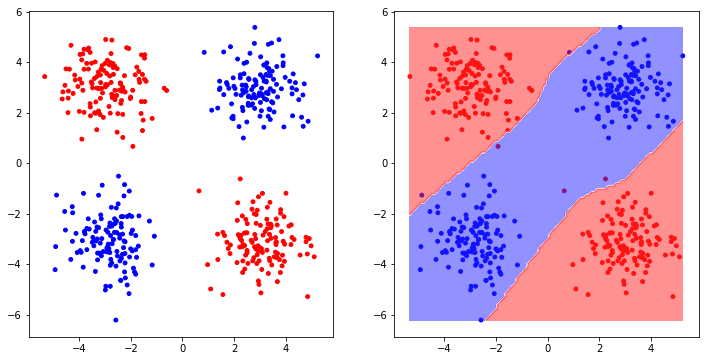

In [43]:
D_in, D_out = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-2)

nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=tanh))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=30000, verbose=3000)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

(500, 2) (500, 1)


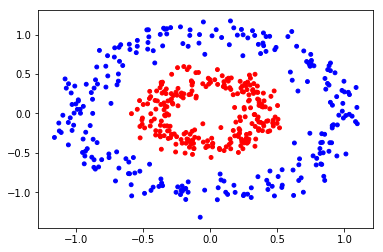

In [44]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/30000 loss_train: 0.94286057
epoch: 3000/30000 loss_train: 0.55722872
epoch: 6000/30000 loss_train: 0.44062825
epoch: 9000/30000 loss_train: 0.25966382
epoch: 12000/30000 loss_train: 0.16616224
epoch: 15000/30000 loss_train: 0.12632938
epoch: 18000/30000 loss_train: 0.10469840
epoch: 21000/30000 loss_train: 0.09126260
epoch: 24000/30000 loss_train: 0.08213613
epoch: 27000/30000 loss_train: 0.07551027
epoch: 30000/30000 loss_train: 0.07044403
Acurácia: 98.60%


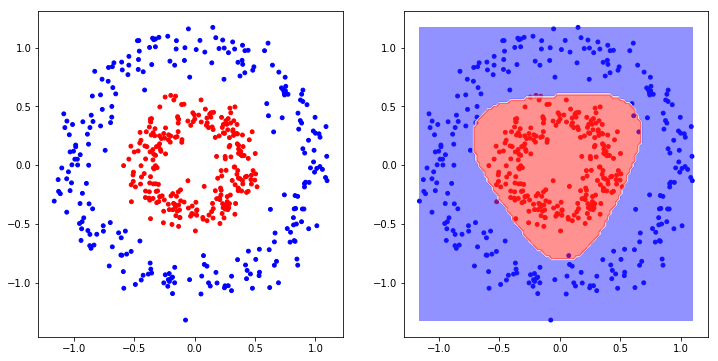

In [45]:
D_in, D_out = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-2)

nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=tanh))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=30000, verbose=3000)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

(200, 2) (200, 1)


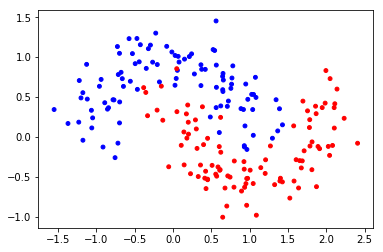

In [46]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/30000 loss_train: 2.01934264
epoch: 3000/30000 loss_train: 0.80928651
epoch: 6000/30000 loss_train: 0.50017614
epoch: 9000/30000 loss_train: 0.41147465
epoch: 12000/30000 loss_train: 0.37469261
epoch: 15000/30000 loss_train: 0.35611635
epoch: 18000/30000 loss_train: 0.34528047
epoch: 21000/30000 loss_train: 0.33815765
epoch: 24000/30000 loss_train: 0.33301528
epoch: 27000/30000 loss_train: 0.32903581
epoch: 30000/30000 loss_train: 0.32579289
Acurácia: 86.50%


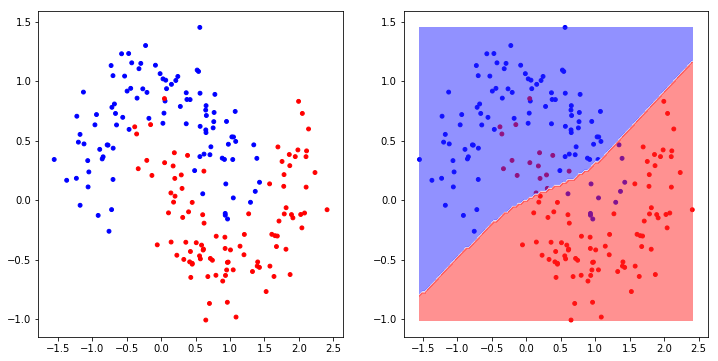

In [49]:
D_in, D_out = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-4)

nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=tanh))
nn.layers.append(Layer(input_dim=5, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=30000, verbose=3000)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

(200, 2) (200, 1)


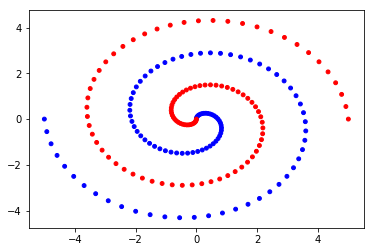

In [50]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

In [ ]:
D_in, D_out = x.shape[1], y.shape[1]

# insira sua rede aqui!

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

In [ ]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [ ]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

In [ ]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
    
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

In [ ]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [ ]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

In [ ]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

(500, 2) (500, 1)


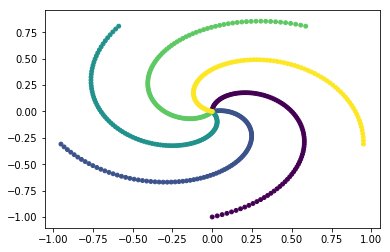

In [51]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [52]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


epoch:    0/10000 loss_train: 1.74209037
epoch: 1000/10000 loss_train: 0.18219698
epoch: 2000/10000 loss_train: 0.11227114
epoch: 3000/10000 loss_train: 0.06061271
epoch: 4000/10000 loss_train: 0.05562619
epoch: 5000/10000 loss_train: 0.06126829
epoch: 6000/10000 loss_train: 0.03866505
epoch: 7000/10000 loss_train: 0.03201448
epoch: 8000/10000 loss_train: 0.02784519
epoch: 9000/10000 loss_train: 0.02711668
epoch: 10000/10000 loss_train: 0.02673490
Acurácia: 99.00%


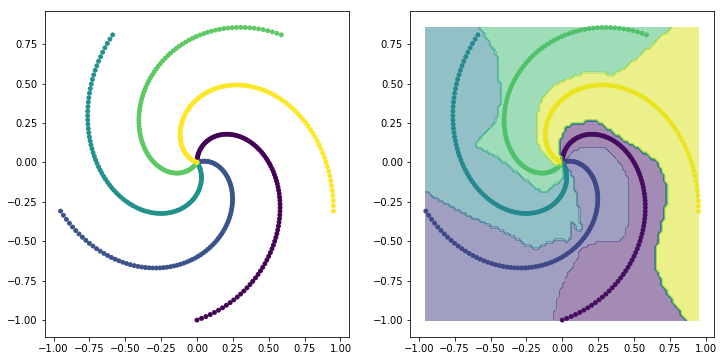

In [57]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)

nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=tanh))
nn.layers.append(Layer(input_dim=5, output_dim=8, activation=tanh))
nn.layers.append(Layer(input_dim=8, output_dim=5, activation=tanh))
nn.layers.append(Layer(input_dim=5, output_dim=8, activation=tanh))
nn.layers.append(Layer(input_dim=8, output_dim=5, activation=tanh))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=10000, verbose=1000)


y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

In [ ]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [ ]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

In [ ]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Iris Dataset

In [ ]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [ ]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

In [ ]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

# [Link para o Questionário](https://docs.google.com/forms/d/e/1FAIpQLSf1B3JKsPPPc1oYD_3FyX4UvNLpcXnTW2I177A_WE0_B56Elw/viewform?usp=sf_link)

# Referências

- [Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

- [Linear Classification](http://cs231n.github.io/linear-classify/)

__Regularization__:
- [Implementing Neural Network L1 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)
- [Implementing Neural Network L2 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/29/implementing-neural-network-l2-regularization/)
- [Neural Network L2 Regularization Using Python](https://visualstudiomagazine.com/articles/2017/09/01/neural-network-l2.aspx)

__Momentum__:
- [Neural Network Momentum Using Python](https://visualstudiomagazine.com/articles/2017/08/01/neural-network-momentum.aspx)
- [Beyond SGD: Gradient Descent with Momentum and Adaptive Learning Rate](https://wiseodd.github.io/techblog/2016/06/22/nn-optimization/)

__Learning Rate Decay__:
- [Using Learning Rate Schedules for Deep Learning Models in Python with Keras](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)
- [Learning Rate Schedules and Adaptive Learning Rate Methods for Deep Learning](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)
- [Tensorflow Exponential Decay Documentation](https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay)

__Batch Normalization__:
- [Understanding the backward pass through Batch Normalization Layer](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
- [Deriving the Gradient for the Backward Pass of Batch Normalization](https://kevinzakka.github.io/2016/09/14/batch_normalization/)
- [Implementing BatchNorm in Neural Net](https://wiseodd.github.io/techblog/2016/07/04/batchnorm/)
- [What does the gradient flowing through batch normalization looks like ?](http://cthorey.github.io./backpropagation/)
- [GRADIENTS, BATCH NORMALIZATION AND LAYER NORMALIZATION](https://theneuralperspective.com/2016/10/27/gradient-topics/)

__Gradient Checking__:
- [cs231n](https://github.com/cs231n/cs231n.github.io/blob/master/neural-networks-3.md#gradcheck)
- [Gradient checking and advanced optimization](http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization)
- [BatchNormalization fails gradient checking](https://github.com/torch/nn/issues/744)